## LKOH sentiment data parsing and posts filtering

### Module imports

In [1]:
import os, sys, re
from tqdm import tqdm
import sqlite3
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import importlib
import scripts.post_parser

importlib.reload(scripts.post_parser)
print('modules reloaded!')

from scripts.post_parser import TinkoffPulseParser

modules reloaded!


In [2]:
current_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(current_dir)
database_path = os.path.join(project_root, 'databases', 'lkoh_posts_2023.db')

### T-Pulse posts parsing

In [2]:
# custom_db = "lkoh_posts_2023.db"
# parser = TinkoffPulseParser(
#     start_date='2023-01-01',
#     db_name=custom_db
# )
# parser.parse_single_ticker("LKOH")

Обрабатывается дата: 2023-01-06T08:02:33.124Z
Получено постов: 97076


2025-03-01 20:00:14,077 - INFO - Достигнута целевая дата 2023-01-01 00:00:00+00:00


### EDA

In [3]:
conn = sqlite3.connect(database_path)
lkoh_posts_2023 = pd.read_sql_query("SELECT * FROM tcs_pulse_posts", conn)

In [4]:
lkoh_posts_2023.head(3)

,id,post_id,inserted,instruments,hashtags,content,reactions_count,comments_count,parse_dt
0,1,2ff674ea-f98b-4c91-9a46-0ebe29a6402a,2025-03-01T11:59:40.414Z,LKOH,None,{$LKOH} как-будто бы торги выходного дня,2,0,2025-03-01 16:09:48
1,2,95afd336-3038-4707-b9ef-f9b0db9f6e0c,2025-03-01T11:28:23.802Z,LKOH,None,{$LKOH} у всех пропали точки сделок на графике...,0,1,2025-03-01 16:09:48
2,3,5cc35c51-f390-4f92-9eb1-c695fd2e5304,2025-03-01T11:12:34.528Z,LKOH,None,Анализ Лукойла {$LKOH}\n\nАкции ЛУКОЙЛ закрыва...,2,1,2025-03-01 16:09:48


Преобразуем дату и посмотрим на динамику публикаций

In [5]:
lkoh_posts_2023['inserted'] = pd.to_datetime(lkoh_posts_2023["inserted"].str[:10])
daily_counts_lkoh = lkoh_posts_2023.groupby('inserted').size().reset_index(name='count')

In [6]:
%load_ext autoreload
%autoreload 2
from scripts.vizualizer import plot_daily_posts

plot_daily_posts(daily_counts_lkoh, "LKOH")

Сохраним общее число публикаций на каждый день будем использовать как дополнительный признак в модели:

In [7]:
lkoh_posts_2023["total_day_posts_cnt"] = lkoh_posts_2023.groupby(by="inserted")[
    "id"
].transform("count")

Также нам важно понимать распределение длин текстов:

In [8]:
lkoh_posts_2023["words_cnt"] = lkoh_posts_2023["content"].apply(
    lambda x: len(x.split())
)
lkoh_posts_2023["post_len"] = lkoh_posts_2023["content"].apply(len)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


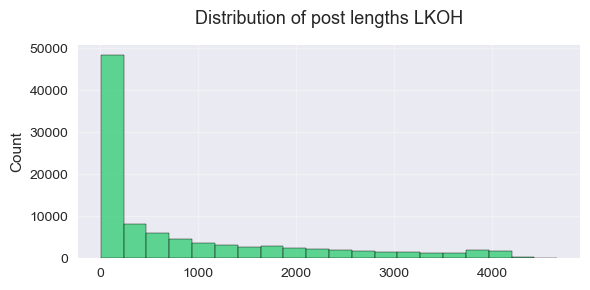

In [9]:
%load_ext autoreload
%autoreload 2
from scripts.vizualizer import plot_posts_length

plot_posts_length(lkoh_posts_2023, 'LKOH', 'post_len', '')

### Content processing

In [10]:
%load_ext autoreload
%autoreload 2
from scripts.post_processer import preprocess_text_base

tqdm.pandas()
lkoh_posts_2023['content_base'] = lkoh_posts_2023['content'].progress_apply(preprocess_text_base)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 97342/97342 [00:02<00:00, 43938.87it/s]


In [11]:
lkoh_posts_2023["instruments"] = lkoh_posts_2023["instruments"].fillna("error")

lkoh_posts_2023["tags"] = 0
lkoh_posts_2023["tags"] = lkoh_posts_2023["instruments"].apply(
    lambda x: ", ".join(sorted(x.split(", ")))
)

In [13]:
lkoh_posts_2023['tags'].value_counts(normalize=True)

LKOH                                                                    0.541072
LKOH, ROSN                                                              0.009503
LKOH, SBER                                                              0.009451
GAZP, LKOH, SBER                                                        0.006534
GAZP, LKOH                                                              0.003318
                                                                          ...   
CHMF, EQMX, LKOH, MOEX, SBER                                            0.000010
AFKS, FESH, HYDR, LKOH, MTLR, OZON, POSI, SBER, SGZH, SMLT, SNGSP, T    0.000010
LKOH, MBNK, MTSS, NLMK, OZON, SBER, T, TATN                             0.000010
LKOH, ROSN, SBER, T, TRNFP                                              0.000010
GAZP, LKOH, SNAP, TSLA, VIPS                                            0.000010
Name: tags, Length: 26128, dtype: float64

In [16]:
lkoh_posts_2023["lkoh_only"] = lkoh_posts_2023["tags"].apply(
    lambda x: 1 if x == "LKOH" else 0
)

In [ ]:
# lkoh_posts_2023['content_base'].sample(350).to_excel('lkoh_posts_example.xlsx', encoding="utf-8", index=False)

In [17]:
ticker = 'LKOH'
lkoh_patterns = [
     r"\{\$LKOH\}",  # Standard ticker format
    r"LKOH",  # Ticker without brackets
    r"ЛУКОЙЛ[а-я]*",  # Full company name with endings
    r"Лук[а-я]*ойл[а-я]*",  # Name variations with case
    r"Лукошк[а-я]*",  # Informal nickname
    r"Лука",  # Short informal name
]

In [18]:
%load_ext autoreload
%autoreload 2

from scripts.post_processer import preprocess_other_tickets

# 2
tqdm.pandas()
lkoh_posts_2023["processed_posts"] = lkoh_posts_2023.progress_apply(
    lambda df: (
        preprocess_other_tickets(df["content_base"], ticker, lkoh_patterns)
        if df["lkoh_only"] == 0
        else df["content_base"]
    ),
    axis=1,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 97342/97342 [00:20<00:00, 4826.65it/s]


In [19]:
%load_ext autoreload
%autoreload 2

from scripts.post_processer import clean_promotional_content

# 3
tqdm.pandas()
lkoh_posts_2023["processed_posts"] = lkoh_posts_2023["processed_posts"].progress_apply(
    lambda x: clean_promotional_content(x)
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 97342/97342 [10:08:25<00:00,  2.67it/s]     


In [20]:
%load_ext autoreload
%autoreload 2

from scripts.post_processer import mark_ticker_only_posts

# 4
lkoh_posts_2023 = mark_ticker_only_posts(lkoh_posts_2023)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 97342/97342 [00:02<00:00, 41669.70it/s]


In [21]:
lkoh_posts_2023['ticker_only'].value_counts()

0    92917
1     4425
Name: ticker_only, dtype: int64

In [22]:
lkoh_posts_processed = lkoh_posts_2023[lkoh_posts_2023['ticker_only'] != 1]

In [23]:
req_cols = [
    "post_id",
    "inserted",
    "tags",
    "hashtags",
    "processed_posts",
    "reactions_count",
    "comments_count",
    "total_day_posts_cnt",
]

lkoh_upload = lkoh_posts_processed[req_cols].reset_index(drop=True)

save_path = os.path.join(project_root, 'processed_data', 'lkoh_processed_full.xlsx')
lkoh_upload.to_excel(save_path, encoding="utf-8", index=False)

In [3]:
import pandas as pd

lkoh_upload = pd.read_excel('lkoh_processed_full.xlsx')

Готовим выборку

In [4]:
lkoh_post_id = lkoh_upload[['post_id', 'processed_posts']]

In [5]:
lkoh_train, lkoh_val = lkoh_post_id[3000:], lkoh_upload[:3000]

lkoh_llm, lkoh_val = lkoh_val[:2500], lkoh_val[2500:]

In [6]:
save_path_train = os.path.join(project_root, 'processed_data', 'lkoh_train.xlsx')
save_path_llm = os.path.join(project_root, 'processed_data', 'lkoh_llm.xlsx')
save_path_val = os.path.join(project_root, 'processed_data', 'lkoh_val.xlsx')

lkoh_train.to_excel(save_path_train, index=False)
lkoh_llm.to_excel(save_path_llm, index=False)
lkoh_val.to_excel(save_path_val, index=False)